###imports

In [ ]:
import zipfile
import os
import shutil
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, Conv2D, MaxPooling2D, Flatten, Dropout,
                                     BatchNormalization, LeakyReLU,DepthwiseConv2D,ReLU,Add,GlobalAveragePooling2D)
from sklearn.metrics import classification_report , confusion_matrix
from tensorflow.keras import regularizers
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy, Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

###Extracting Dataset

In [ ]:
def extract_dataset() :
  zip_path = '/content/Teeth DataSet.zip'
  extract_path = ''
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
      zip_ref.extractall(extract_path)


In [ ]:
extract_dataset()

In [ ]:
train_ds_path = "/content/Teeth_Dataset/Training"
test_ds_path='/content/Teeth_Dataset/Testing'
val_ds_path='/content/Teeth_Dataset/Validation'

###Remove test incorrect files

In [ ]:
for dirpath, dirnames, filenames in os.walk(test_ds_path):
  for dir in dirnames :
    if dir in ["output","outputs","out"] :
      shutil.rmtree(os.path.join(test_ds_path,dir))

os.remove(os.path.join(test_ds_path,'output_image.jpg'))

###Load DataSet

In [ ]:
batch_size = 128
img_size = (128, 128)
train = tf.keras.utils.image_dataset_from_directory(
    train_ds_path,
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True
)
val = tf.keras.utils.image_dataset_from_directory(
    val_ds_path,
    labels='inferred',
    label_mode='int',
    batch_size=1,
    image_size=img_size,
    shuffle=True
)
test = tf.keras.utils.image_dataset_from_directory(
    test_ds_path,
    labels='inferred',
    label_mode='int',
    batch_size=1,
    image_size=img_size,
    shuffle=True
)

Found 3087 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.


In [ ]:
class_to_index=dict()
for index,name in enumerate(train.class_names) :
  class_to_index[name]=index
print(class_to_index)

{'CaS': 0, 'CoS': 1, 'Gum': 2, 'MC': 3, 'OC': 4, 'OLP': 5, 'OT': 6}


### Visualization one Batch

Images batch shape: (128, 128, 128, 3)
Labels batch shape: (128,)


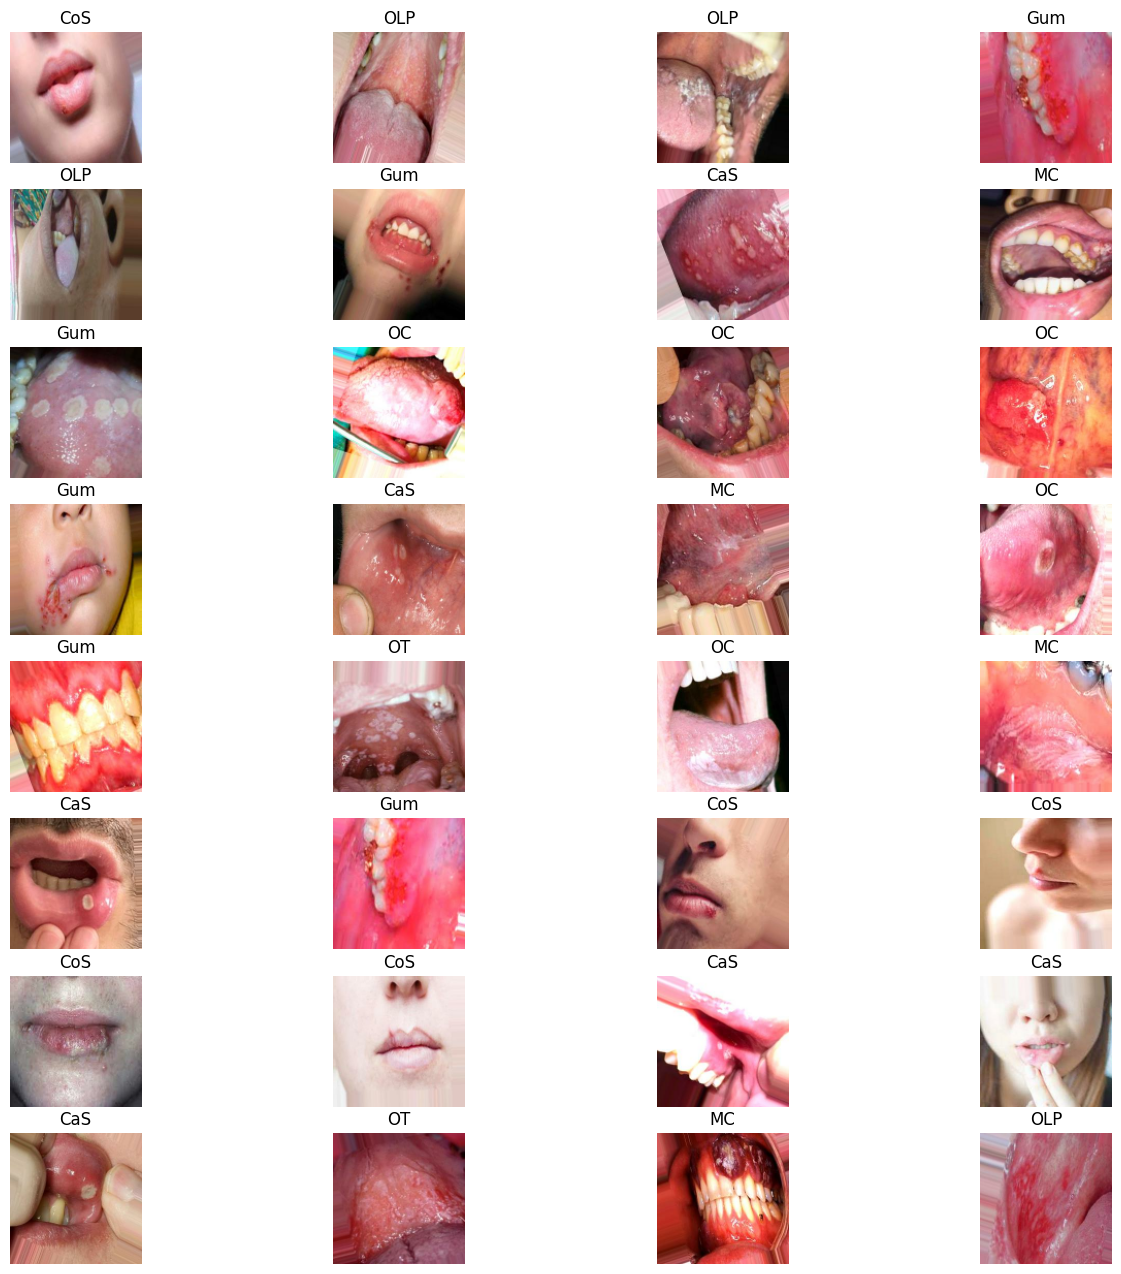

In [ ]:
for images, labels in train.take(1):
    print("Images batch shape:", images.shape)
    print("Labels batch shape:", labels.shape)
    plt.figure(figsize=(16, 16))
    for index in range(32) :
      ax = plt.subplot(8, 4, index+1)
      plt.imshow(images[index].numpy().astype("uint8"))
      plt.title(train.class_names[labels[index]])
      plt.axis("off")
    plt.show()

###Preprocessing

In [ ]:
normalization = tf.keras.layers.Rescaling(1./255)

train = train.map(lambda x, y: (normalization(x), y))
val = val.map(lambda x, y: (normalization(x), y))
test = test.map(lambda x, y: (normalization(x), y))

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomRotation(0.2),
])

In [ ]:
def augment_selected(x, y):
    condition = tf.reduce_any(tf.equal(y, [2, 4, 6]))

    return tf.cond(
        condition,
        lambda: (data_augmentation(x, training=True), y),
        lambda: (x, y)
    )
train_after_augmentation = train.map(augment_selected)

###Visualization

In [ ]:
distribute_classes=dict()
for dirpath, dirnames, filenames in os.walk(train_ds_path):
  for dir in dirnames :
    fulldir = os.path.join(train_ds_path,dir)
    distribute_classes[dir]= len(os.listdir(fulldir))
print(distribute_classes)

{'CaS': 480, 'MC': 540, 'OLP': 540, 'OC': 324, 'OT': 393, 'Gum': 360, 'CoS': 450}


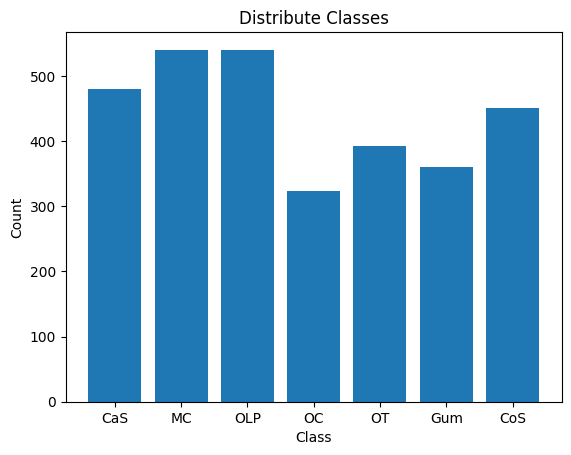

In [ ]:
plt.bar(distribute_classes.keys(),distribute_classes.values())
plt.title("Distribute Classes")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

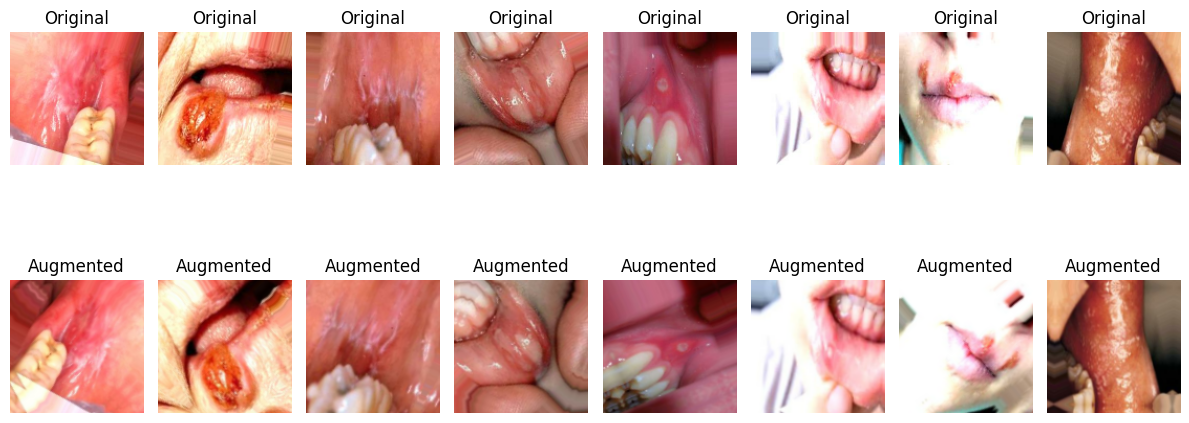

In [ ]:
for images, labels in train.take(1):
    plt.figure(figsize=(12, 6))

    for i in range(8):
        ax = plt.subplot(2, 8, i + 1)
        img = images[i]
        plt.imshow(tf.cast((img*255), tf.uint8))
        plt.title("Original")
        plt.axis("off")

        ax = plt.subplot(2, 8, i + 1 + 8)
        aug_img = data_augmentation(tf.expand_dims(img, 0))
        plt.imshow(tf.cast((aug_img[0]*255), tf.uint8))
        plt.title("Augmented")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


#Model

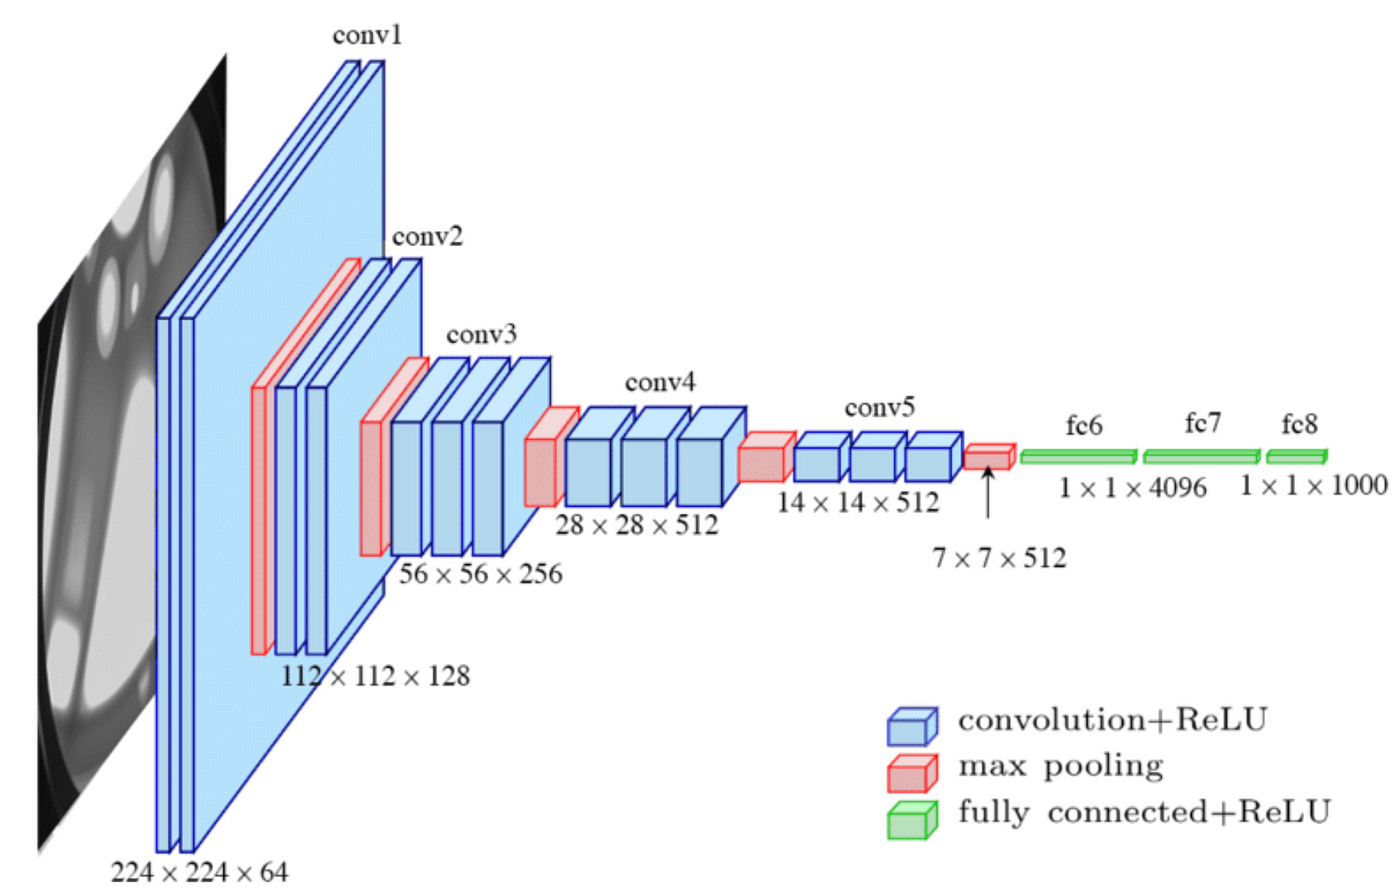

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='leaky_relu', kernel_initializer=HeNormal(),
           kernel_regularizer=regularizers.l2(0.001), input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='leaky_relu', kernel_initializer=HeNormal(),
           kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='leaky_relu', kernel_initializer=HeNormal(),
           kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(256, (3, 3), activation='leaky_relu', kernel_initializer=HeNormal(),
           kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.3),


    Conv2D(512, (3, 3), activation='leaky_relu',padding='same', kernel_initializer=HeNormal(),
           kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.4),


    Conv2D(512, (3, 3), activation='leaky_relu', padding='same',kernel_initializer=HeNormal(),
           kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Flatten(),

    Dense(512, activation='leaky_relu', kernel_initializer="he_normal",
          kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),

    Dense(512, activation='leaky_relu', kernel_initializer="he_normal",
          kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),

    Dense(7, activation='softmax')
])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,457,287 (17.00 MB)

 Trainable params: 4,457,287 (17.00 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer=AdamW( learning_rate=1e-4,weight_decay=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping= tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=10,
    mode="auto",
    restore_best_weights=True,
    verbose=1
)

In [ ]:
weight = {
    class_to_index[k]: 3087 / (7 * v)
    for k,v in distribute_classes.items()
}

print(weight)

{0: 0.91875, 3: 0.8166666666666667, 5: 0.8166666666666667, 4: 1.3611111111111112, 6: 1.1221374045801527, 2: 1.225, 1: 0.98}


In [ ]:
history=model.fit(train, epochs=150,validation_data=val ,
                  callbacks=[early_stopping],
                  verbose=1,class_weight=weight)

Epoch 1/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 578ms/step - accuracy: 0.1502 - loss: 14.3625 - val_accuracy: 0.1148 - val_loss: 6.9967
Epoch 2/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 297ms/step - accuracy: 0.1531 - loss: 7.3549 - val_accuracy: 0.1877 - val_loss: 6.9772
Epoch 3/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - accuracy: 0.1544 - loss: 7.1068 - val_accuracy: 0.2101 - val_loss: 6.9641
Epoch 4/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 297ms/step - accuracy: 0.1462 - loss: 7.0404 - val_accuracy: 0.2432 - val_loss: 6.9489
Epoch 5/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - accuracy: 0.1624 - loss: 7.0012 - val_accuracy: 0.2140 - val_loss: 6.9322
Epoch 6/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 297ms/step - accuracy: 0.1490 - loss: 6.9687 - val_accuracy: 0.2442 - val_loss: 6.9140
Epoch 7/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step - accuracy: 0.1688 - loss: 6.9376 - val_accuracy: 0.2218 - val_loss: 6.8971
Epoch 8/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - accuracy: 0.1731 - loss: 6.9349 - val_a

In [ ]:
loss, acc = model.evaluate(test, verbose=1)
print('Accuracy: {:5.2f}%'.format(100 * acc))
print('Loss: {:5.2f}'.format(loss))


1028/1028 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9052 - loss: 3.6031
Accuracy: 91.15%
Loss:  3.58


In [ ]:
pred = model.predict(test)

true_labels = np.concatenate([y for x, y in test], axis=0)

predicted_labels = np.argmax(pred, axis=1)

print(classification_report(true_labels, predicted_labels))

1028/1028 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
              precision    recall  f1-score   support

           0       0.14      0.12      0.13       160
           1       0.17      0.19      0.18       149
           2       0.17      0.17      0.17       120
           3       0.22      0.23      0.23       180
           4       0.21      0.21      0.21       108
           5       0.22      0.21      0.21       180
           6       0.17      0.18      0.17       131

    accuracy                           0.19      1028
   macro avg       0.19      0.19      0.19      1028
weighted avg       0.19      0.19      0.19      1028



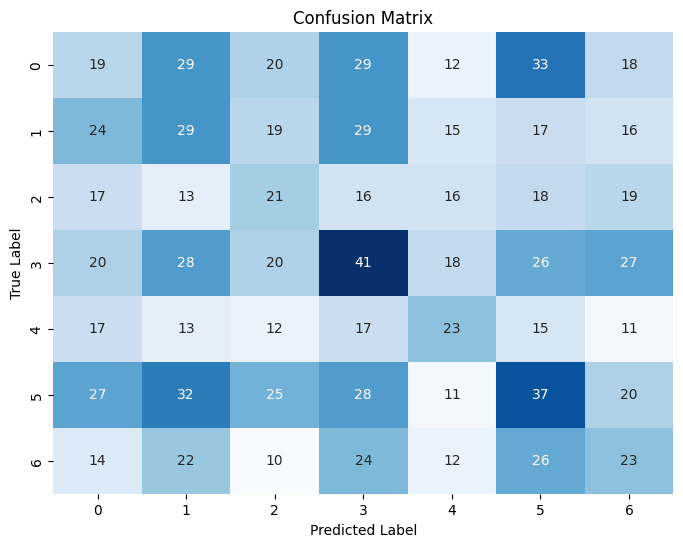

In [ ]:
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()